In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from config import BASE_DIR
from src.baselines.utils import create_adjacency_matrix
%load_ext autoreload
%autoreload 2

## Data and pre-processing

In [3]:
from config import get_paths_by_domain

exp_dir = f"{BASE_DIR}/experiments/dss/clustering_by_scroll"
DOMAIN = "dss"
paths = get_paths_by_domain(DOMAIN)

DATA_CSV_PATH = paths["data_csv_path"]

df_name = os.path.splitext(os.path.basename(DATA_CSV_PATH))[0]

df = pd.read_csv(DATA_CSV_PATH)

In [5]:
from src.baselines.embeddings import VectorizerProcessor
from src.baselines.embeddings import get_bert_models

vectorizers = get_bert_models(DOMAIN) + ["trigram", "tfidf", "starr"]

processor = VectorizerProcessor(df, paths["processed_vectorizers_path"], vectorizers)
processed_vectorizers = processor.load_or_generate_embeddings()

adjacency_matrix_all = create_adjacency_matrix(
    df,
    context_similiarity_window=3,
    composition_level=False,
)

Loaded the embeddings: ['dicta-il/BEREL', 'onlplab/alephbert-base', 'dicta-il/dictabert', 'yonatanlou/BEREL-finetuned-DSS-maskedLM', 'tfidf', 'trigram', 'starr', 'yonatanlou/alephbert-base-finetuned-DSS-maskedLM', 'yonatanlou/dictabert-finetuned-DSS-maskedLM', 'dicta-il/MsBERT']
Loaded the following embeddings dict_keys(['dicta-il/BEREL', 'onlplab/alephbert-base', 'dicta-il/dictabert', 'yonatanlou/BEREL-finetuned-DSS-maskedLM', 'tfidf', 'trigram', 'starr', 'yonatanlou/alephbert-base-finetuned-DSS-maskedLM', 'yonatanlou/dictabert-finetuned-DSS-maskedLM', 'dicta-il/MsBERT'])


Building adjacency matrix: 100%|██████████| 978/978 [00:00<00:00, 1244.45it/s]


### Add labels
For matching each chunk to it label, the main issue in in the edge cases, where the chunk have 2 labels.
Im assigning the label the majority of the chunk is in.

In [7]:
# Define your labels with their corresponding ranges
labels_1QS = {
    "1QS=1:1 – 3:12": (1, 1, 3, 12),
    "1QS=3:13 – 4:26": (3, 13, 4, 26),
    "1QS=5:1 – 6:23": (5, 1, 6, 23),
    "1QS=6:24 – 7:25": (6, 24, 7, 25),
    "1QS=8:1 – 8:19": (8, 1, 8, 19),
    "1QS=8:20 – 9:11": (8, 20, 9, 11),
    "1QS=9:12 – 9:26": (9, 12, 9, 26),
    "1QS=10:1 – 11:22": (10, 1, 11, 22),
    "1QSa=all": (1000, 1000, 1000, 1000)
}

labels_hodayot = {
    "1QHa=Non-teacher hymns": (3, 1, 8, 28),  #3:1–8:28+17:38–23:16
    "1QHa=Debated teacher hymns": (9, 1, 10, 19),  #9:1 – 10:19
    "1QHa=Teacher hymns": (10, 20, 17, 36),  #10:20 – 17:36
    "1QHa=Non-teacher hymns_2": (17, 38, 23, 16),  #3:1–8:28+17:38–23:16
    "1QHa=allTheRest": (23, 16, 1, 1)

}

labels_1QM = {
    "1QM=1:1 – 1:18": (1, 1, 1, 18),
    "1QM=allTheRest": (2, 1, 10000, 1000),

}


def parse_range(sentence_path):
    start, end = sentence_path.split('-')
    scroll = start.split(":")[0]

    start = start.split(":")[1:]
    start_chapter, start_verse = map(int, start)

    end_chapter, end_verse = map(int, end.split(':'))
    return scroll, start_chapter, start_verse, end_chapter, end_verse


def calculate_overlap(start_chapter, start_verse, end_chapter, end_verse, l_start_chapter, l_start_verse, l_end_chapter,
                      l_end_verse):
    # Convert the start and end points to a comparable single number (e.g., verse count)
    start = start_chapter * 1000 + start_verse
    end = end_chapter * 1000 + end_verse
    l_start = l_start_chapter * 1000 + l_start_verse
    l_end = l_end_chapter * 1000 + l_end_verse

    # Calculate overlap
    overlap_start = max(start, l_start)
    overlap_end = min(end, l_end)
    overlap = max(0, overlap_end - overlap_start)
    return overlap


def match_label(sentence_path, labels):
    scroll, start_chapter, start_verse, end_chapter, end_verse = parse_range(sentence_path)
    if scroll == "1QSa":
        return "1QSa"

    max_overlap = 0
    best_label = None

    for label, (l_start_chapter, l_start_verse, l_end_chapter, l_end_verse) in labels.items():
        if label.startswith(scroll):  # Ensure we are matching the correct scroll
            overlap = calculate_overlap(start_chapter, start_verse, end_chapter, end_verse, l_start_chapter,
                                        l_start_verse, l_end_chapter, l_end_verse)
            if overlap > max_overlap:
                max_overlap = overlap
                best_label = label
    if not best_label:
        best_label = [lab for lab in labels.keys() if "allTheRest" in lab][0]
    return best_label


def label_sentence_path(df_labeled_for_clustering, labels, verbose=True):
    sentence_paths = df_labeled_for_clustering["sentence_path"].to_list()
    results = []
    for sentence_path in sentence_paths:
        try:
            label = match_label(sentence_path, labels)
        except:

            label = [lab for lab in labels.keys() if "allTheRest" in lab][0]
        results.append((sentence_path, label))
        if verbose:
            print(f"Sentence Path: {sentence_path} -> Label: {label}")

    df_labeled_for_clustering = df_labeled_for_clustering.copy()
    df_labeled_for_clustering.loc[:, "label"] = [i[1] for i in results]
    df_labeled_for_clustering = df_labeled_for_clustering[
        df_labeled_for_clustering["label"] != "1QHa=allTheRest"]  #not relevant anymore
    df_labeled_for_clustering["label"] = df_labeled_for_clustering["label"].replace(
        {"1QHa=Non-teacher hymns_2": "1QHa=Non-teacher hymns"})
    return df_labeled_for_clustering

# 
# curr_scroll = ["1QHa"]
# df_labeled_for_clustering = df[df["book"].isin(curr_scroll)]
# df_labeled_for_clustering = label_sentence_path(df_labeled_for_clustering, labels_hodayot,verbose=True)
# df_labeled_for_clustering

## Functions

In [8]:

from src.baselines.utils import calculate_jaccard_unsupervised, clustering_accuracy
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sknetwork.hierarchy import dasgupta_score as calculate_dasgupta_score
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
import scipy


def round_metrics(metrics, n=3):
    new_metrics = {}
    for k, v in metrics.items():
        new_metrics[k] = np.round(v, n)
    return new_metrics


def cluster_and_get_metrics(df_labeled_for_clustering, embeddings_tmp, adjacency_matrix_tmp, linkage_m):
    n_clusters = len(df_labeled_for_clustering['label'].unique())
    linkage_matrix = linkage(embeddings_tmp, method=linkage_m)

    # Calculate Jaccard Index
    flat_clusters = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
    le = LabelEncoder()
    true_labels_encoded = le.fit_transform(df_labeled_for_clustering['label'])
    jaccard = calculate_jaccard_unsupervised(true_labels_encoded, flat_clusters)
    silhouette = silhouette_score(embeddings_tmp, flat_clusters)

    dasgupta = calculate_dasgupta_score(adjacency_matrix_tmp, linkage_matrix)
    clustering_acc = clustering_accuracy(true_labels_encoded, flat_clusters)

    metrics = {
        "silhouette": silhouette,
        "jaccard": jaccard,
        "dasgupta": dasgupta,
        "clustering_accuracy": clustering_acc,
    }
    return linkage_matrix, metrics


def generate_dendrogram_plot(df_labeled_for_clustering, linkage_matrix, vec_type, metrics, curr_scroll,
                             label_to_plot="sentence_path"):
    if label_to_plot not in ["sentence_path", "label"]:
        raise
    metrics = round_metrics(metrics)

    # Create a color map based on the 'label' column
    unique_labels = df_labeled_for_clustering['label'].unique()
    label_colors = plt.cm.copper(np.linspace(0, 1, len(unique_labels)))
    color_map = dict(zip(unique_labels, label_colors))

    # Plot the dendrogram
    plt.figure(figsize=(10, 14))  # Swap width and height for vertical orientation
    dendrogram(
        linkage_matrix,
        labels=df_labeled_for_clustering[label_to_plot].tolist(),
        orientation='left',  # This makes the dendrogram vertical
        leaf_font_size=6,
        leaf_rotation=0  # Horizontal text for better readability
    )
    plt.yticks(fontsize=10)

    plt.title(f'embeddings: {vec_type}, {metrics}')
    plt.ylabel('Sentence Path')  # Swap x and y labels
    plt.xlabel('Distance')
    plt.suptitle(f"{curr_scroll} scroll clustering")
    # Color the y-axis labels according to their labels
    ax = plt.gca()
    ylbls = ax.get_ymajorticklabels()
    for idx, lbl in enumerate(ylbls):
        if label_to_plot == "sentence_path":
            label = \
                df_labeled_for_clustering[df_labeled_for_clustering["sentence_path"] == lbl.get_text()]["label"].values[
                    0]
        else:
            label = lbl.get_text()
        lbl.set_color(color_map[label])
        lbl.set_text(label)

    # Add a legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                                  markerfacecolor=color, markersize=10)
                       for label, color in color_map.items()]
    plt.legend(handles=legend_elements, title='Labels', loc='best', bbox_to_anchor=(0, 1))

    plt.tight_layout()
    plt.show()


def hirerchial_clustering_by_scroll(df: pd.DataFrame, curr_scroll: list[str], labels: dict, vec_type: str,
                                    processed_vectorizers: dict, adjacency_matrix, label_to_plot, kwargs):
    linkage_m = kwargs["linkage_m"]
    #get labels
    df_labeled_for_clustering = df[df["book"].isin(curr_scroll)]
    df_labeled_for_clustering = label_sentence_path(df_labeled_for_clustering, labels, verbose=False)

    #get embeddings
    embeddings = processed_vectorizers[vec_type]
    label_idxs = list(df_labeled_for_clustering.index)
    adjacency_matrix_tmp = adjacency_matrix[label_idxs, :][
                           :, label_idxs]
    embeddings_tmp = embeddings[label_idxs]
    if type(embeddings_tmp) == scipy.sparse._csr.csr_matrix:
        embeddings_tmp = embeddings_tmp.toarray()

    #get metrics and linkage
    linkage_matrix, metrics = cluster_and_get_metrics(df_labeled_for_clustering, embeddings_tmp, adjacency_matrix_tmp,
                                                      linkage_m)

    #plot
    if label_to_plot:
        generate_dendrogram_plot(df_labeled_for_clustering, linkage_matrix, vec_type, metrics, curr_scroll,
                                 label_to_plot)
    return metrics



## P values per metric - deprecated
For constructing the p-values, im running hirerchial clustering 100 times, each time with 70% of the data.
In each itereation, im generaring random features.
Im generating 3 different metrics for each embedding type for each scroll (ari, dasgupta, jaccard).
For each metric, i can get p-value by asking for each scroll->embedding->metric is the metric is higher than the random features.
So i will get for each scroll, for each embedding, for each metric a p value.

In [126]:
# from src.baselines.utils import set_seed_globally
# from tqdm.notebook import tqdm
# 
# set_seed_globally(435)
# 
# all_scrolls_to_cluster = [["1QHa"], ["1QS", "1QSa"], ["1QM"]]
# all_labels = [labels_hodayot, labels_1QS, labels_1QM]
# linkage_methods = ['ward']
# ITERS = 50
# FRAC = 0.7
# all_res_for_p_vals = []
# for curr_scroll, labels in tqdm(zip(all_scrolls_to_cluster, all_labels)):
#     for _ in tqdm(range(ITERS)):
#         df_tmp = df[df["book"].isin(curr_scroll)]
#         df_tmp = df_tmp.sample(frac=FRAC)
#         for vec_type in vectorizers + ["random"]:
#             if vec_type == "random":
#                 processed_vectorizers["random"] = random_array = np.random.rand(df.shape[0], 1000)
#             for linkage_tmp in linkage_methods:
#                 kwargs = {"linkage_m": linkage_tmp}
#                 tmp_metrics = hirerchial_clustering_by_scroll(df_tmp, curr_scroll, labels, vec_type,
#                                                               processed_vectorizers, adjacency_matrix_all, None, kwargs)
#                 tmp_metrics.update({"vectorizer": vec_type, "scroll": curr_scroll, "n_labels": len(labels)})
#                 tmp_metrics.update(kwargs)
#                 all_res_for_p_vals.append(tmp_metrics)
# 
# 
# 
# import pandas as pd
# from scipy.stats import mannwhitneyu
# 
# # Assuming results DataFrame is already created
# results = pd.DataFrame(all_res_for_p_vals)
# results["scroll"] = results["scroll"].astype(str)
# 
# # Initialize a list to store the results
# p_values = []
# 
# # Loop through each unique scroll
# for scroll in results['scroll'].unique():
#     # Filter the results for the current scroll
#     results_one_scroll = results[results['scroll'] == scroll]
# 
#     # Loop through each unique vectorizer
#     for vectorizer in results_one_scroll['vectorizer'].unique():
#         if vectorizer == "random":
#             continue  # Skip the random vectorizer itself
# 
#         # Initialize a dictionary to store p-values for the current scroll and vectorizer
#         p_value_dict = {'scroll': scroll, 'vectorizer': vectorizer}
# 
#         # Loop through each metric: 'jaccard', 'ari', 'dasgupta'
#         for metric in ['jaccard', 'clustering_accuracy', 'silhouette', 'dasgupta']:
#             # Get the embeddings for the current vectorizer
#             tmp_embedding = results_one_scroll[results_one_scroll['vectorizer'] == vectorizer][metric]
#             random_embedding = results_one_scroll[results_one_scroll['vectorizer'] == "random"][metric]
# 
#             # Perform the Mann-Whitney U test
#             u_stat, p_value = mannwhitneyu(tmp_embedding, random_embedding)
# 
#             # Store the p-value in the dictionary
#             p_value_dict[f'{metric}_p_value'] = np.round(p_value, 6)
# 
#         # Append the dictionary to the list
#         p_values.append(p_value_dict)
# 
# # Convert the list to a DataFrame
# p_values_df = pd.DataFrame(p_values)
# 
# # Display the results
# p_values_df.sort_values(by=['scroll', 'vectorizer'], inplace=True)
# p_values_df


0it [00:00, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

My main question here is which embeddings to use for each scroll.
I have 3 metrics for each scroll, embeddings with p-values.

Im running hirerchial clustering for each scroll, for each embedding (now on the full data).
Metrics that have p-value < 0.05 will become 0.
Then, i normalizing each metric, and doing a weighted average on all metrics, and taking the top for each scroll.
I can do it by two ways - 


In [50]:
# from src.baselines.utils import set_seed_globally
# from tqdm.notebook import tqdm
# 
# set_seed_globally(42)
# 
# all_scrolls_to_cluster = [["1QHa"], ["1QS", "1QSa"], ["1QM"]]
# all_labels = [labels_hodayot, labels_1QS, labels_1QM]
# linkage_methods = ['ward']
# all_res = []
# for curr_scroll, labels in tqdm(zip(all_scrolls_to_cluster, all_labels)):
#     for vec_type in vectorizers:
#         processed_vectorizers["random"] = random_array = np.random.rand(df.shape[0], 1000)
#         for linkage_tmp in linkage_methods:
#             kwargs = {"linkage_m": linkage_tmp}
#             tmp_metrics = hirerchial_clustering_by_scroll(df, curr_scroll, labels, vec_type, processed_vectorizers,
#                                                           adjacency_matrix_all, None, kwargs)
#             tmp_metrics.update({"vectorizer": vec_type, "scroll": curr_scroll, "n_labels": len(labels)})
#             tmp_metrics.update(kwargs)
#             all_res.append(tmp_metrics)
# 
# 
# import pandas as pd
# 
# def process_metrics(all_res, p_values_df, metrics, p_threshold=0.05):
#     results = pd.DataFrame(all_res)
#     results["scroll"] = results["scroll"].astype(str)
#     results = pd.merge(results, p_values_df, on=["scroll", "vectorizer"])
#     
#     # Process each metric
#     normalized_cols = []
#     rank_cols = []
#     for m in metrics:
#         # Zero out non-significant results
#         sig_col = f"{m}_w_significance"
#         results[sig_col] = results[m]
#         results.loc[results[f'{m}_p_value'] > p_threshold, sig_col] = 0
#         
#         # Normalize and rank
#         norm_col = f"{m}_normalized"
#         rank_col = f"{m}_rank"
#         results[norm_col] = results.groupby('scroll')[sig_col].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
#         results[rank_col] = results.groupby('scroll')[sig_col].rank(method='min', ascending=False)
#         
#         normalized_cols.append(norm_col)
#         rank_cols.append(rank_col)
#     
#     # Calculate combined results
#     results["normalized_results"] = results[normalized_cols].mean(axis=1)
#     results["ranked_results"] = results[rank_cols].mean(axis=1)
#     
#     return results.sort_values(by=["scroll", "normalized_results"], ascending=False)
# 
# 
# results = process_metrics(all_res, p_values_df, metrics=['jaccard', 'clustering_accuracy', 'silhouette', 'dasgupta'])
# results


0it [00:00, ?it/s]

### best results by Accuracy

In [9]:
from src.baselines.utils import set_seed_globally
from tqdm.notebook import tqdm

labels_all = {"['1QM']": labels_1QM, "['1QHa']": labels_hodayot, "['1QS', '1QSa']": labels_1QS}
set_seed_globally(42)

all_scrolls_to_cluster = [["1QHa"], ["1QS", "1QSa"], ["1QM"]]
all_labels = [labels_hodayot, labels_1QS, labels_1QM]
linkage_methods = ['ward']
all_res = []
for curr_scroll, labels in tqdm(zip(all_scrolls_to_cluster, all_labels)):
    for vec_type in vectorizers:
        processed_vectorizers["random"] = random_array = np.random.rand(df.shape[0], 1000)
        for linkage_tmp in linkage_methods:
            kwargs = {"linkage_m": linkage_tmp}
            tmp_metrics = hirerchial_clustering_by_scroll(df, curr_scroll, labels, vec_type, processed_vectorizers,
                                                          adjacency_matrix_all, None, kwargs)
            tmp_metrics.update({"vectorizer": vec_type, "scroll": curr_scroll, "n_labels": len(labels)})
            tmp_metrics.update(kwargs)
            all_res.append(tmp_metrics)



0it [00:00, ?it/s]

In [10]:
results = pd.DataFrame(all_res)
results["scroll"] = results["scroll"].astype(str)
results.sort_values(by=["scroll", "jaccard"], ascending=False)

,silhouette,jaccard,dasgupta,clustering_accuracy,vectorizer,scroll,n_labels,linkage_m
10,0.086068,0.523810,0.701708,0.795918,dicta-il/BEREL,"['1QS', '1QSa']",9,ward
14,0.088521,0.517766,0.733233,0.775510,yonatanlou/BEREL-finetuned-DSS-maskedLM,"['1QS', '1QSa']",9,ward
18,0.042057,0.434066,0.768369,0.653061,tfidf,"['1QS', '1QSa']",9,ward
12,0.071828,0.280172,0.590579,0.612245,dicta-il/dictabert,"['1QS', '1QSa']",9,ward
13,0.075874,0.272358,0.609080,0.591837,dicta-il/MsBERT,"['1QS', '1QSa']",9,ward
17,0.049689,0.268182,0.632572,0.551020,trigram,"['1QS', '1QSa']",9,ward
11,0.097250,0.245734,0.681909,0.612245,onlplab/alephbert-base,"['1QS', '1QSa']",9,ward
16,0.077350,0.241667,0.613665,0.571429,yonatanlou/dictabert-finetuned-DSS-maskedLM,"['1QS', '1QSa']",9,ward
15,0.089688,0.204461,0.626973,0.551020,yonatanlou/alephbert-base-finetuned-DSS-maskedLM,"['1QS', '1QSa']",9,ward
19,0.830267,0.111245,0.360693,0.285714,starr,"['1QS', '1QSa']",9,ward


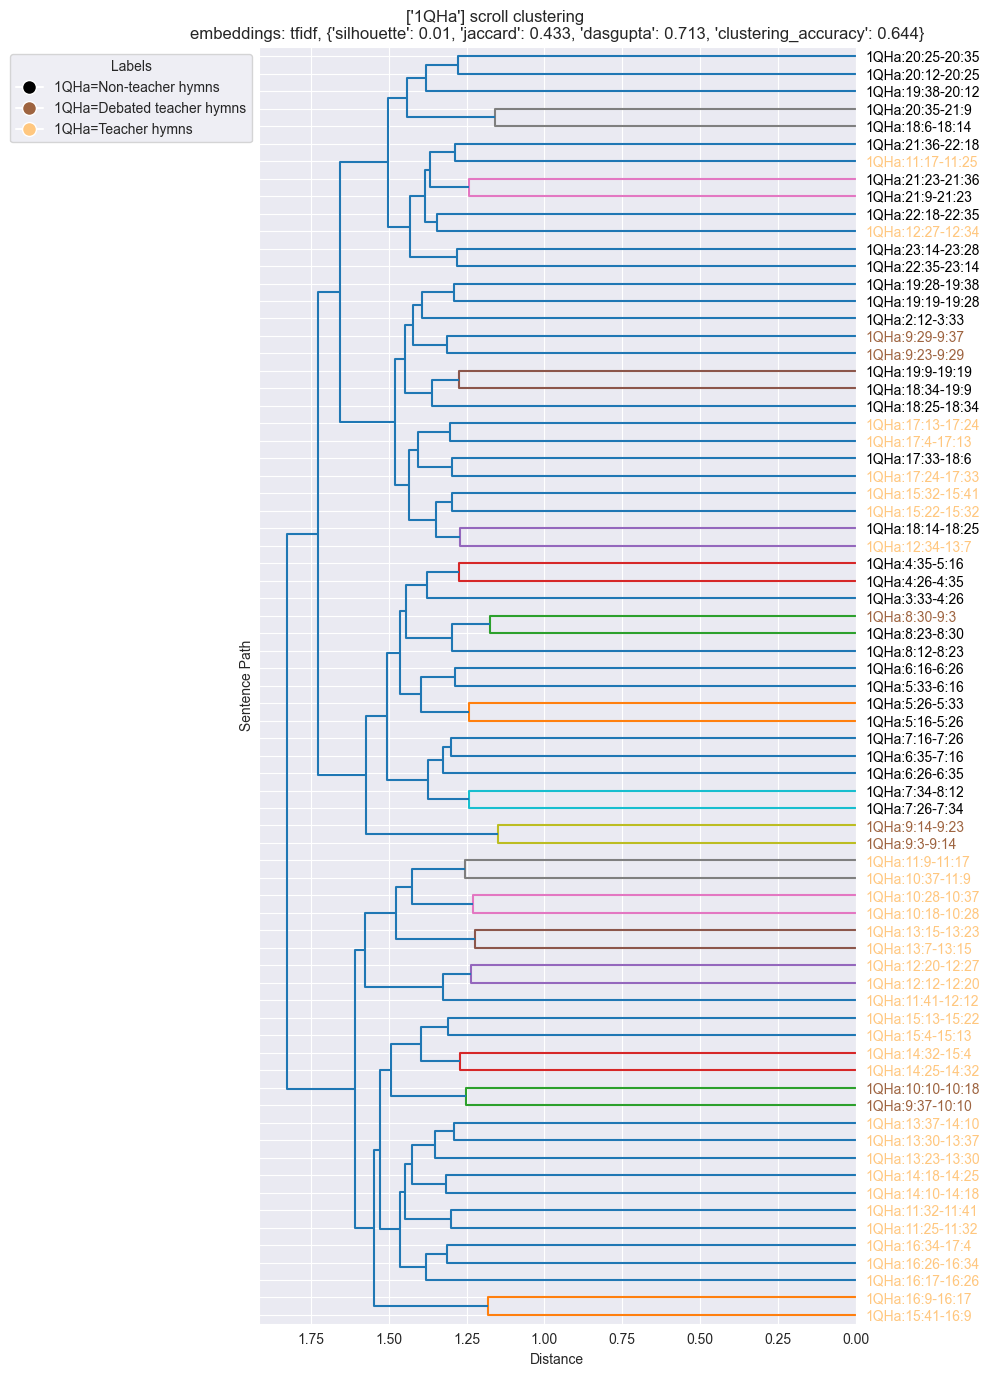

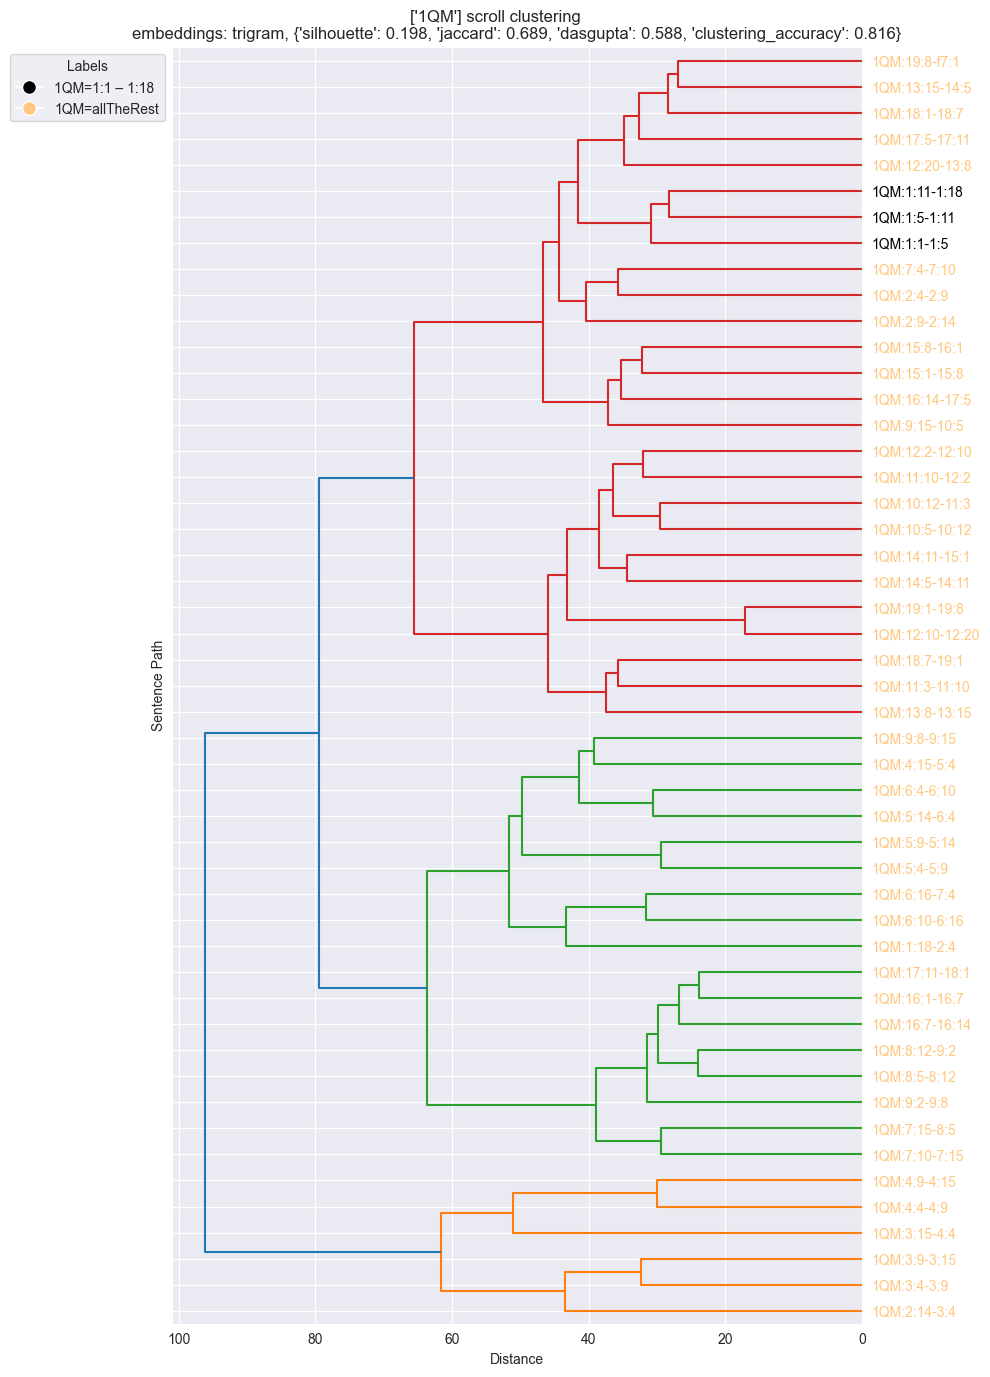

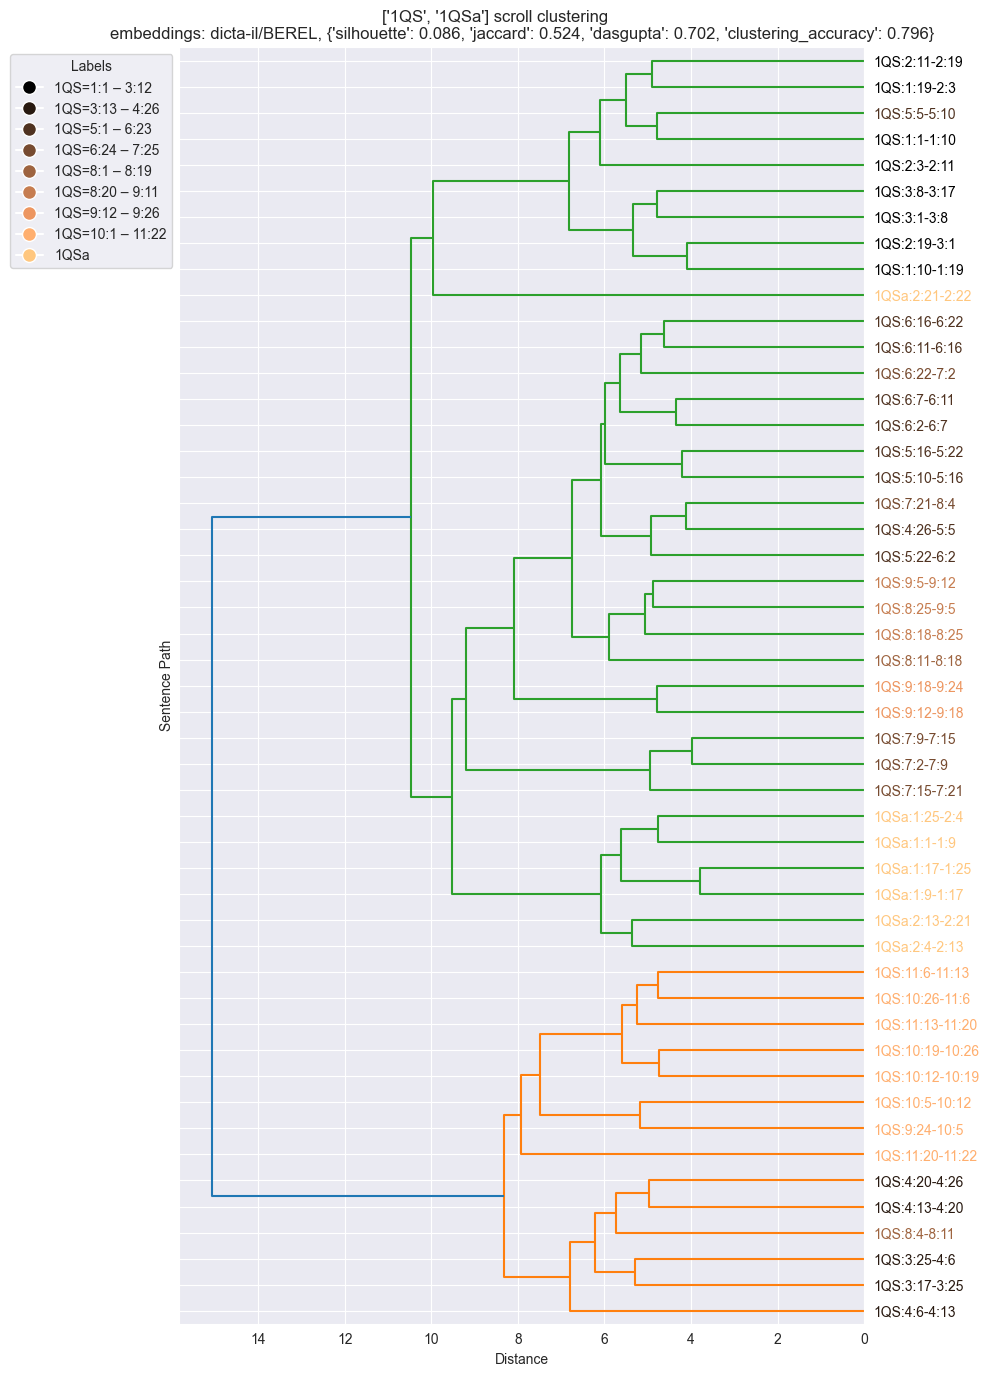

In [12]:
for i, row in results.loc[results.groupby("scroll")["clustering_accuracy"].idxmax()].iterrows():
    scroll_name = row['scroll']
    hirerchial_clustering_by_scroll(df, eval(row['scroll']), labels_all[row['scroll']], row['vectorizer'],
                                    processed_vectorizers, adjacency_matrix_all, "sentence_path", {"linkage_m": "ward"})

## Stacking features + PCA - deprecated
Looks like it not giving better results

In [13]:
from sklearn.decomposition import PCA


def stack_embeddings_and_pca(processed_vectorizers, vectorizer_to_stack, out_dim=768):
    embeddings_lst = []
    for vec_name in vectorizer_to_stack:
        tmp_arr = processed_vectorizers[vec_name]
        if isinstance(tmp_arr, scipy.sparse.csr_matrix):
            tmp_arr = tmp_arr.toarray()  # Convert sparse to dense
        embeddings_lst.append(tmp_arr)

    stacked_embeddings = np.hstack(embeddings_lst)
    print(f"Shape of stacked embeddings: {stacked_embeddings.shape}")

    pca = PCA(n_components=out_dim)
    pca.fit(stacked_embeddings)
    pca_emb = pca.transform(stacked_embeddings)
    print(f"Shape of PCA embeddings: {pca_emb.shape}")
    return pca_emb


def hirerchial_clustering_by_scroll_stacked_vectorizers(df: pd.DataFrame, curr_scroll: list[str], labels: dict,
                                                        vec_type: list[str],
                                                        processed_vectorizers: dict, adjacency_matrix, label_to_plot,
                                                        kwargs):
    linkage_m = kwargs["linkage_m"]
    #get labels
    df_labeled_for_clustering = df[df["book"].isin(curr_scroll)]
    df_labeled_for_clustering = label_sentence_path(df_labeled_for_clustering, labels, verbose=False)

    #get embeddings
    embeddings = stack_embeddings_and_pca(processed_vectorizers, vec_type, out_dim=768)
    label_idxs = list(df_labeled_for_clustering.index)
    adjacency_matrix_tmp = adjacency_matrix[label_idxs, :][
                           :, label_idxs]
    embeddings_tmp = embeddings[label_idxs]
    if type(embeddings_tmp) == scipy.sparse._csr.csr_matrix:
        embeddings_tmp = embeddings_tmp.toarray()

    #get metrics and linkage
    linkage_matrix, metrics = cluster_and_get_metrics(df_labeled_for_clustering, embeddings_tmp, adjacency_matrix_tmp,
                                                      linkage_m)

    #plot
    if label_to_plot:
        generate_dendrogram_plot(df_labeled_for_clustering, linkage_matrix, vec_type, metrics, curr_scroll,
                                 label_to_plot)
    return metrics


In [15]:
results.loc[results.groupby("scroll")["jaccard"].idxmax()]

,silhouette,jaccard,dasgupta,clustering_accuracy,vectorizer,scroll,n_labels,linkage_m
8,0.010445,0.432727,0.713463,0.643836,tfidf,['1QHa'],5,ward
27,0.198404,0.689119,0.588115,0.816327,trigram,['1QM'],2,ward
10,0.086068,0.523810,0.701708,0.795918,dicta-il/BEREL,"['1QS', '1QSa']",9,ward


In [16]:
curr_best = results.loc[results.groupby("scroll")["jaccard"].idxmax()]

vectorizer_to_stack = ['dicta-il/BEREL', 'trigram', 'tfidf']

stats_pca = []

for i, row in curr_best.iterrows():
    scroll_name = row['scroll']
    metrics = hirerchial_clustering_by_scroll_stacked_vectorizers(df, eval(row['scroll']), labels_all[row['scroll']],
                                                                  vectorizer_to_stack,
                                                                  processed_vectorizers, adjacency_matrix_all, None,
                                                                  {"linkage_m": "ward"})
    metrics.update({"scroll": eval(row['scroll']), "vectorizer": str(vectorizer_to_stack)})
    stats_pca.append(metrics)

Shape of stacked embeddings: (978, 25674)
Shape of PCA embeddings: (978, 768)
Shape of stacked embeddings: (978, 25674)
Shape of PCA embeddings: (978, 768)
Shape of stacked embeddings: (978, 25674)
Shape of PCA embeddings: (978, 768)


In [17]:
stats_df_pca = pd.DataFrame(stats_pca)
stats_df_pca["vectorizer"] = stats_df_pca["vectorizer"].astype(str)
stats_df_pca["scroll"] = stats_df_pca["scroll"].astype(str)
stats_df_pca.sort_values(by=["scroll", "dasgupta"], ascending=False)


,silhouette,jaccard,dasgupta,clustering_accuracy,scroll,vectorizer
2,0.050315,0.268182,0.628596,0.551020,"['1QS', '1QSa']","['dicta-il/BEREL', 'trigram', 'tfidf']"
1,0.197173,0.689119,0.609346,0.816327,['1QM'],"['dicta-il/BEREL', 'trigram', 'tfidf']"
0,0.055231,0.297647,0.561312,0.493151,['1QHa'],"['dicta-il/BEREL', 'trigram', 'tfidf']"


In [20]:

results.sort_values(by=["scroll", "dasgupta"], ascending=False)


,silhouette,jaccard,dasgupta,clustering_accuracy,vectorizer,scroll,n_labels,linkage_m
18,0.042057,0.434066,0.768369,0.653061,tfidf,"['1QS', '1QSa']",9,ward
14,0.088521,0.517766,0.733233,0.775510,yonatanlou/BEREL-finetuned-DSS-maskedLM,"['1QS', '1QSa']",9,ward
10,0.086068,0.523810,0.701708,0.795918,dicta-il/BEREL,"['1QS', '1QSa']",9,ward
11,0.097250,0.245734,0.681909,0.612245,onlplab/alephbert-base,"['1QS', '1QSa']",9,ward
17,0.049689,0.268182,0.632572,0.551020,trigram,"['1QS', '1QSa']",9,ward
15,0.089688,0.204461,0.626973,0.551020,yonatanlou/alephbert-base-finetuned-DSS-maskedLM,"['1QS', '1QSa']",9,ward
16,0.077350,0.241667,0.613665,0.571429,yonatanlou/dictabert-finetuned-DSS-maskedLM,"['1QS', '1QSa']",9,ward
13,0.075874,0.272358,0.609080,0.591837,dicta-il/MsBERT,"['1QS', '1QSa']",9,ward
12,0.071828,0.280172,0.590579,0.612245,dicta-il/dictabert,"['1QS', '1QSa']",9,ward
19,0.830267,0.111245,0.360693,0.285714,starr,"['1QS', '1QSa']",9,ward


### GNN
Trained a GNN model on scroll classification, and used the embeddings for the within scroll clustering.
There is no data leakage, because we trained on seperate scrolls.

The results are still not beating the good old TF-idf, but it did improved the BERT embeddings

In [21]:
from src.gnn.model import GCN
from src.gnn.adjacency import AdjacencyMatrixGenerator
import torch

# bert_model = "yonatanlou/BEREL-finetuned-DSS-maskedLM"
bert_model = "dicta-il/BEREL"
param_dict = {
    "num_adjs": 1,
    "epochs": 500,
    "hidden_dim": 300,
    "distance": "cosine",
    "learning_rate": 0.001,
    "threshold": 0.98,
    "adjacencies": [{"type": "tfidf", "params": {"max_features": 7500}}],
    # "bert_model": "yonatanlou/alephbert-base-finetuned-DSS-maskedLM",
    "bert_model": bert_model,
}

GNN_MODEL_PATH = f"{BASE_DIR}/models/gcn_model_train_on_scroll.pth"
kwargs, state = torch.load(GNN_MODEL_PATH)
model = GCN(**kwargs)
model.load_state_dict(state)

adj_gen = AdjacencyMatrixGenerator(
    vectorizer_type=param_dict["adjacencies"][0]["type"],
    vectorizer_params=param_dict["adjacencies"][0]["params"],
    threshold=param_dict["threshold"],
    distance_metric=param_dict["distance"],
    meta_params=None,
    normalize=True,
)
df = pd.read_csv(DATA_CSV_PATH)
df_ = df[df["book"].isin(["1QM", "1QSa", '1QS', "1QHa"])]
edge_index, edge_attr, adj_matrix = adj_gen.generate_graph(df_)
X = processed_vectorizers[param_dict["bert_model"]]
X = X[df_.index]
X = X.astype("float32")
X_tensor = torch.FloatTensor(X)

model.eval()
with torch.no_grad():
    embeddings = model.get_embeddings(X_tensor, edge_index, edge_attr)

embeddings_gnn = embeddings.numpy()

2024-11-17 13:38:05.934620 - tfidf n edges before filtering: 31818, n edges after filtering: 648


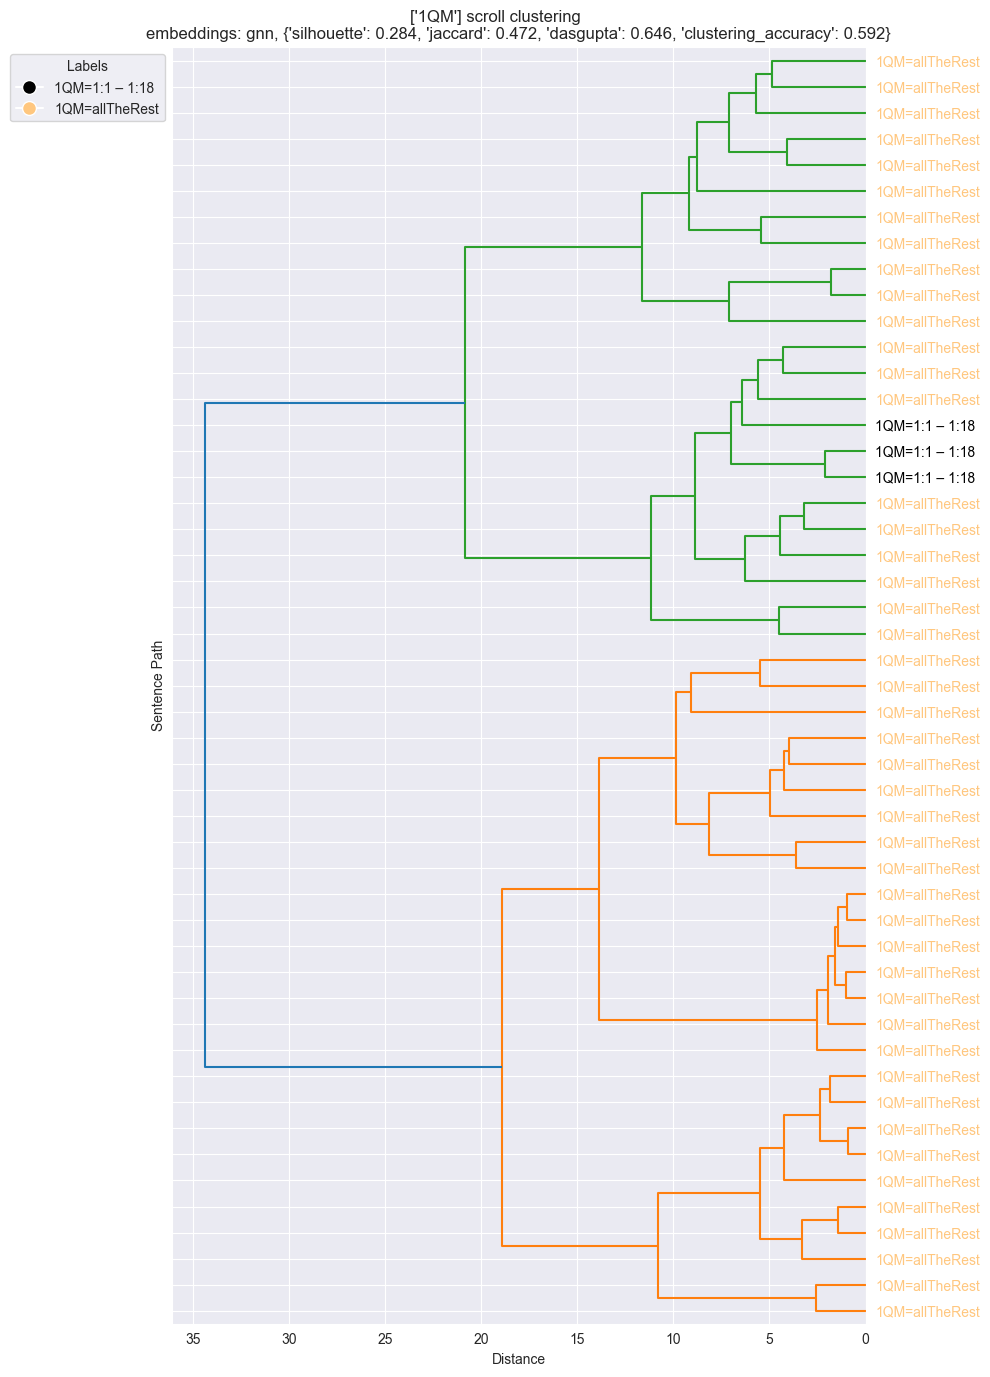

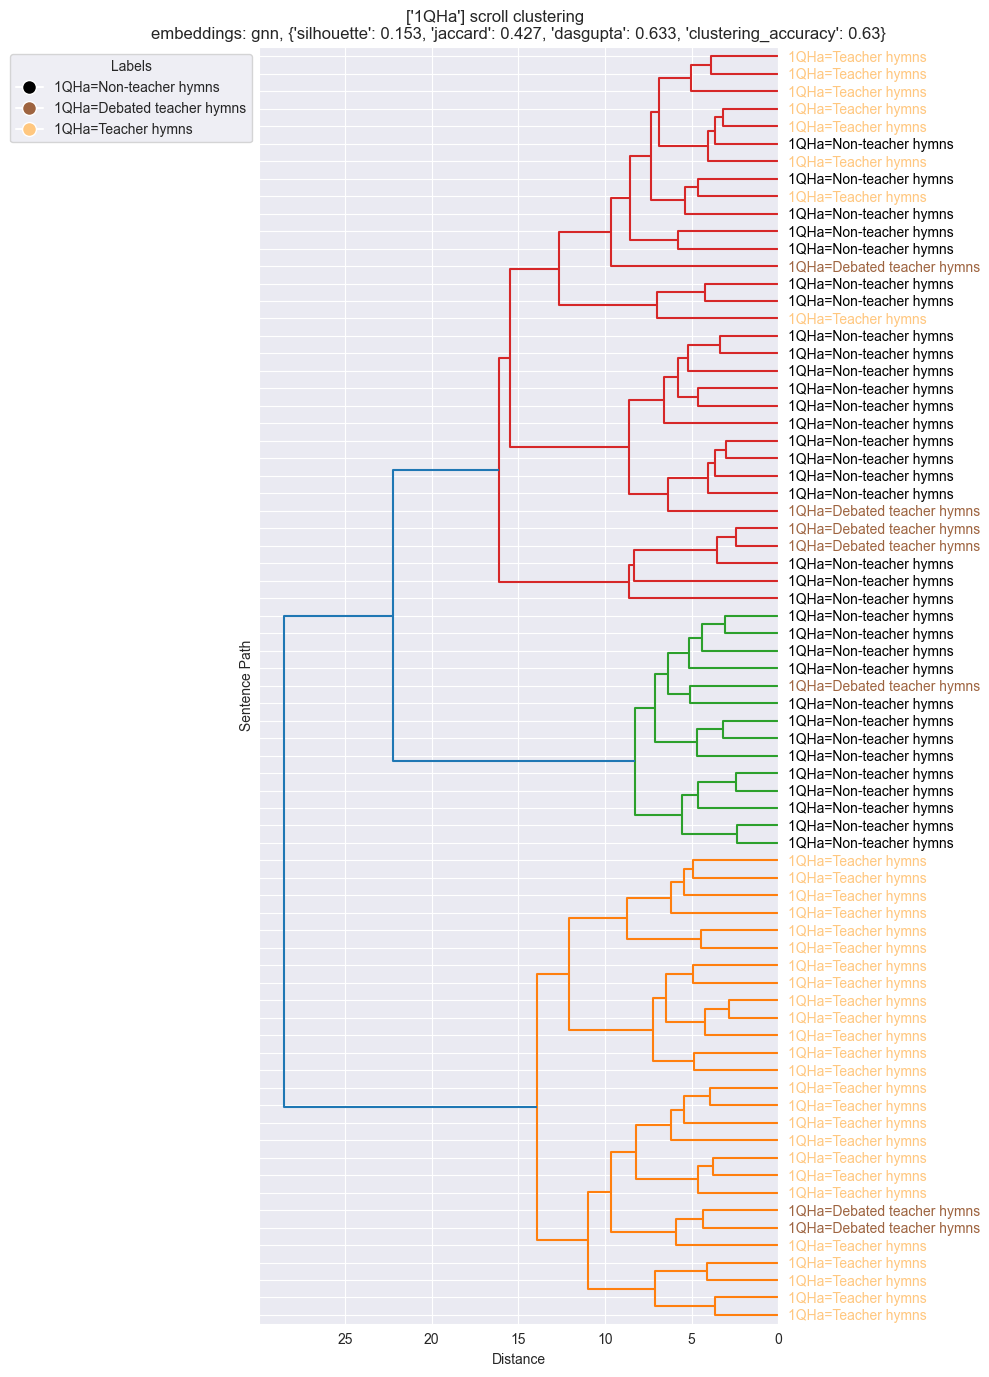

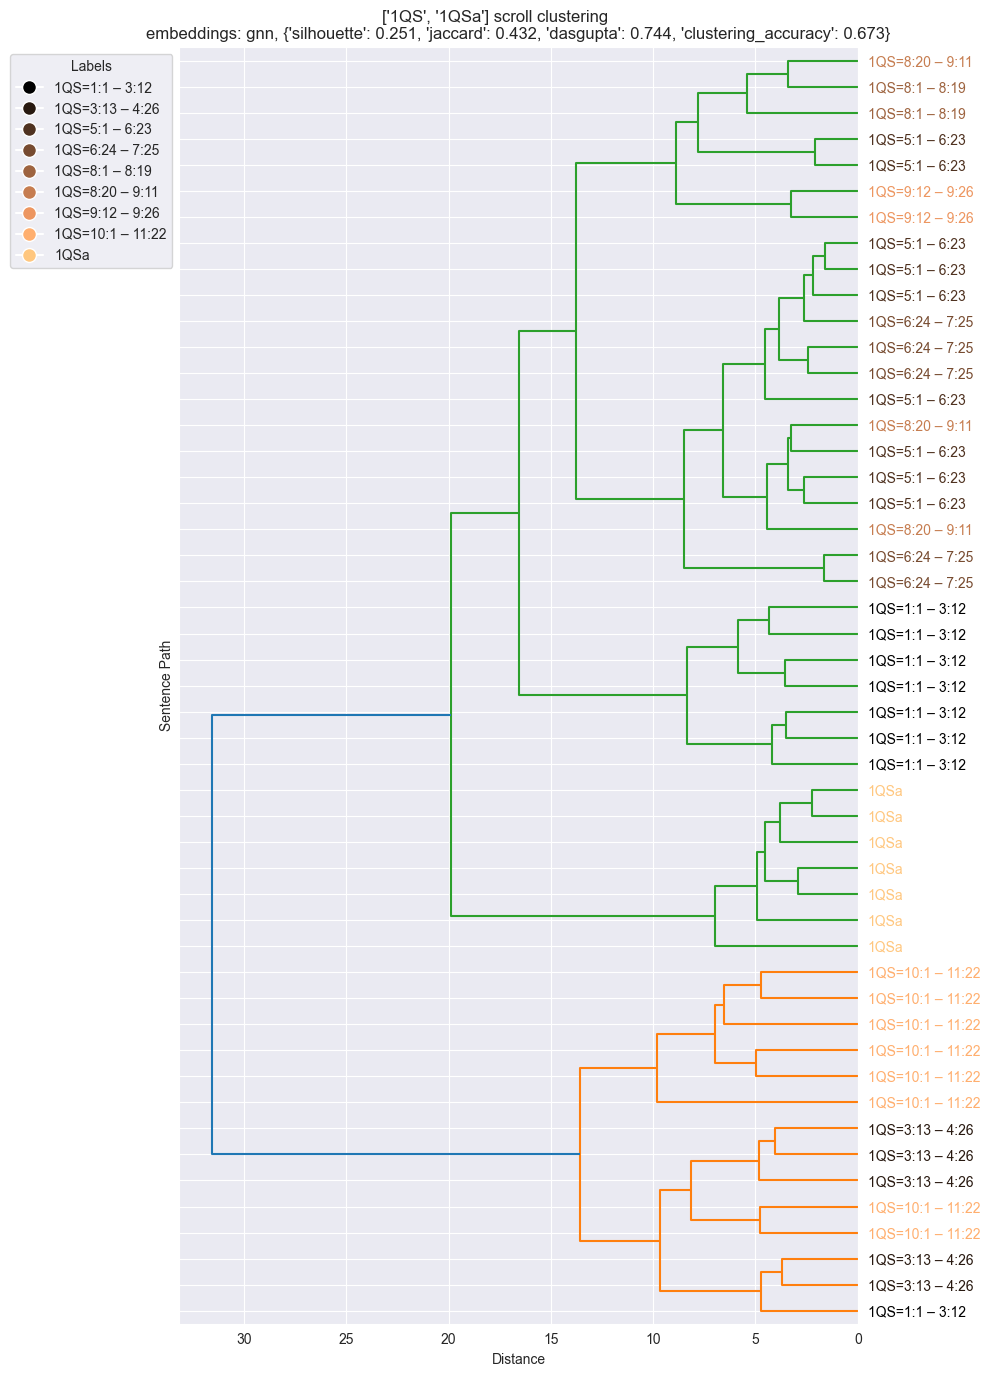

In [22]:
def hirerchial_clustering_by_scroll_gnn(df: pd.DataFrame, curr_scroll: list[str], labels: dict, vec_type, embeddings,
                                        adjacency_matrix, label_to_plot, kwargs):
    linkage_m = kwargs["linkage_m"]

    df = df.reset_index()
    #get labels
    df_labeled_for_clustering = df[df["book"].isin(curr_scroll)]
    df_labeled_for_clustering = label_sentence_path(df_labeled_for_clustering, labels, verbose=False)
    idxs_global = df_labeled_for_clustering["index"]
    #get embeddings
    label_idxs = list(df_labeled_for_clustering.index)
    adjacency_matrix_tmp = adjacency_matrix[idxs_global, :][
                           :, idxs_global]
    embeddings_tmp = embeddings[label_idxs]
    if type(embeddings_tmp) == scipy.sparse._csr.csr_matrix:
        embeddings_tmp = embeddings_tmp.toarray()

    #get metrics and linkage
    linkage_matrix, metrics = cluster_and_get_metrics(df_labeled_for_clustering, embeddings_tmp, adjacency_matrix_tmp,
                                                      linkage_m)

    #plot
    if label_to_plot:
        generate_dendrogram_plot(df_labeled_for_clustering, linkage_matrix, vec_type, metrics, curr_scroll,
                                 label_to_plot)
    return metrics


labels_all = {
    "['1QM']": labels_1QM,
    "['1QHa']": labels_hodayot, "['1QS', '1QSa']": labels_1QS
}
all_metrics = []
for scroll in labels_all.keys():
    metrics_gnn = hirerchial_clustering_by_scroll_gnn(df_, eval(scroll), labels_all[scroll], "gnn", embeddings_gnn,
                                                      adjacency_matrix_all, "label", {"linkage_m": "ward"})
    metrics_gnn.update({"scroll": scroll, "vectorizer": f"gnn-{bert_model}"})
    all_metrics.append(metrics_gnn)

In [23]:
gnn_results_on_berel = pd.DataFrame(all_metrics)
# berel_results = results[results["vectorizer"].str.contains("BEREL")]
berel_results = results
pd.concat([gnn_results_on_berel, berel_results[gnn_results_on_berel.columns]]).sort_values(
    by=["scroll", "clustering_accuracy"],
    ascending=False)

,silhouette,jaccard,dasgupta,clustering_accuracy,scroll,vectorizer
10,0.086068,0.523810,0.701708,0.795918,"['1QS', '1QSa']",dicta-il/BEREL
14,0.088521,0.517766,0.733233,0.775510,"['1QS', '1QSa']",yonatanlou/BEREL-finetuned-DSS-maskedLM
2,0.250930,0.431925,0.744229,0.673469,"['1QS', '1QSa']",gnn-dicta-il/BEREL
18,0.042057,0.434066,0.768369,0.653061,"['1QS', '1QSa']",tfidf
11,0.097250,0.245734,0.681909,0.612245,"['1QS', '1QSa']",onlplab/alephbert-base
12,0.071828,0.280172,0.590579,0.612245,"['1QS', '1QSa']",dicta-il/dictabert
13,0.075874,0.272358,0.609080,0.591837,"['1QS', '1QSa']",dicta-il/MsBERT
16,0.077350,0.241667,0.613665,0.571429,"['1QS', '1QSa']",yonatanlou/dictabert-finetuned-DSS-maskedLM
15,0.089688,0.204461,0.626973,0.551020,"['1QS', '1QSa']",yonatanlou/alephbert-base-finetuned-DSS-maskedLM
17,0.049689,0.268182,0.632572,0.551020,"['1QS', '1QSa']",trigram


### GVAE

In [96]:

from src.gnn.model import GVAE
from src.gnn.adjacency import AdjacencyMatrixGenerator
import torch

bert_model = "yonatanlou/BEREL-finetuned-DSS-maskedLM"
param_dict = {
    "num_adjs": 1,
    "epochs": 500,
    "hidden_dim": 300,
    "distance": "cosine",
    "learning_rate": 0.001,
    "threshold": 0.98,
    "adjacencies": [{"type": "tfidf", "params": {"max_features": 7500}}],
    "bert_model": bert_model,
}

GVAE_MODEL_PATH = f"{BASE_DIR}/models/gvae_model.pth"
kwargs, state = torch.load(GVAE_MODEL_PATH)
model = GVAE(**kwargs)
model.load_state_dict(state)
model.eval()

adj_gen = AdjacencyMatrixGenerator(
    vectorizer_type=param_dict["adjacencies"][0]["type"],
    vectorizer_params=param_dict["adjacencies"][0]["params"],
    threshold=param_dict["threshold"],
    distance_metric=param_dict["distance"],
    meta_params=None,
    normalize=True,
)
df = pd.read_csv(DATA_CSV_PATH)
df_ = df[df["book"].isin(["1QM", "1QSa", '1QS', "1QHa"])]
edge_index, edge_attr, adj_matrix = adj_gen.generate_graph(df_)
X = processed_vectorizers[param_dict["bert_model"]]
X = X[df_.index]
X = X.astype("float32")
X_tensor = torch.FloatTensor(X)

model.eval()
with torch.no_grad():
    _, mu, _ = model(X_tensor, edge_index, edge_attr)
embeddings_gvae = mu.numpy()


2024-11-16 17:43:14.704774 - tfidf n edges before filtering: 31818, n edges after filtering: 648


In [97]:
labels_all = {"['1QM']": labels_1QM, "['1QHa']": labels_hodayot, "['1QS', '1QSa']": labels_1QS}
all_metrics = []
for scroll in labels_all.keys():
    metrics_gnn = hirerchial_clustering_by_scroll_gnn(df_, eval(scroll), labels_all[scroll], "gnn", embeddings_gvae,
                                                      adjacency_matrix_all, None, {"linkage_m": "ward"})
    metrics_gnn.update({"scroll": scroll, "vectorizer": f"GVAE-{bert_model}"})
    all_metrics.append(metrics_gnn)

In [99]:
gnn_results_on_bert = pd.DataFrame(all_metrics)
combined_results = pd.concat([gnn_results_on_bert, results[gnn_results_on_bert.columns]])
combined_results.sort_values(by=["scroll", "clustering_accuracy"], ascending=False)

,silhouette,jaccard,dasgupta,clustering_accuracy,scroll,vectorizer
10,0.086068,0.523810,0.701708,0.795918,"['1QS', '1QSa']",dicta-il/BEREL
14,0.088521,0.517766,0.733233,0.775510,"['1QS', '1QSa']",yonatanlou/BEREL-finetuned-DSS-maskedLM
2,0.260265,0.532609,0.715057,0.755102,"['1QS', '1QSa']",GVAE-yonatanlou/BEREL-finetuned-DSS-maskedLM
18,0.042057,0.434066,0.768369,0.653061,"['1QS', '1QSa']",tfidf
11,0.097250,0.245734,0.681909,0.612245,"['1QS', '1QSa']",onlplab/alephbert-base
12,0.071828,0.280172,0.590579,0.612245,"['1QS', '1QSa']",dicta-il/dictabert
13,0.075874,0.272358,0.609080,0.591837,"['1QS', '1QSa']",dicta-il/MsBERT
16,0.077350,0.241667,0.613665,0.571429,"['1QS', '1QSa']",yonatanlou/dictabert-finetuned-DSS-maskedLM
17,0.049689,0.268182,0.632572,0.551020,"['1QS', '1QSa']",trigram
15,0.089688,0.204461,0.626973,0.551020,"['1QS', '1QSa']",yonatanlou/alephbert-base-finetuned-DSS-maskedLM


Checking all GVAE berts:


In [24]:

from src.baselines.embeddings import get_bert_models
from src.gnn.model import GVAE
from src.gnn.adjacency import AdjacencyMatrixGenerator
import torch

param_dict = {
    "num_adjs": 1,
    "epochs": 500,
    "hidden_dim": 300,
    "distance": "cosine",
    "learning_rate": 0.001,
    "threshold": 0.98,
    "adjacencies": [{"type": "tfidf", "params": {"max_features": 7500}}],
    # "bert_model": bert_model,
}

adj_gen = AdjacencyMatrixGenerator(
    vectorizer_type=param_dict["adjacencies"][0]["type"],
    vectorizer_params=param_dict["adjacencies"][0]["params"],
    threshold=param_dict["threshold"],
    distance_metric=param_dict["distance"],
    meta_params=None,
    normalize=True,
)
df = pd.read_csv(DATA_CSV_PATH)
df_ = df[df["book"].isin(["1QM", "1QSa", '1QS', "1QHa"])]
edge_index, edge_attr, adj_matrix = adj_gen.generate_graph(df_)

# Labels setup
labels_all = {
    "['1QM']": labels_1QM,
    "['1QHa']": labels_hodayot,
    "['1QS', '1QSa']": labels_1QS
}

# Get all model files
models_dir = "/Users/yonatanlou/dev/QumranNLP/models"
model_files = [f for f in os.listdir(models_dir) if f.endswith('.pth')]

# Process each model
all_results = []
for bert_model in tqdm(get_bert_models(DOMAIN)):
    for model_file in model_files:
        model_path = os.path.join(models_dir, model_file)

        # Load model
        kwargs, state = torch.load(model_path)
        if any(["gcn" in k for k in state.keys()]):
            print("GCN model, passing")
            continue
        model = GVAE(**kwargs)
        model.load_state_dict(state)
        model.eval()

        param_dict["bert_model"] = bert_model
        X = processed_vectorizers[param_dict["bert_model"]]
        X = X[df_.index]
        X = X.astype("float32")
        X_tensor = torch.FloatTensor(X)

        # Get embeddings
        with torch.no_grad():
            _, mu, _ = model(X_tensor, edge_index, edge_attr)
        embeddings_gvae = mu.numpy()

        # Calculate metrics for each scroll
        for scroll in labels_all.keys():
            metrics_gnn = hirerchial_clustering_by_scroll_gnn(
                df_,
                eval(scroll),
                labels_all[scroll],
                "gnn",
                embeddings_gvae,
                adjacency_matrix_all,
                None,
                {"linkage_m": "ward"}
            )
            metrics_gnn.update({
                "scroll": scroll,
                "vectorizer": f"GVAE-{bert_model}",
                "model_file": model_file  # Add model filename to track which model was used
            })
            all_results.append(metrics_gnn)

# Create final results DataFrame
gnn_results_all = pd.DataFrame(all_results)
combined_results = pd.concat([gnn_results_all, results[gnn_results_all.columns.drop('model_file')]])
final_results = combined_results.sort_values(by=["scroll", "clustering_accuracy"], ascending=False)


2024-11-17 13:40:08.141058 - tfidf n edges before filtering: 31818, n edges after filtering: 648


  0%|          | 0/7 [00:00<?, ?it/s]

GCN model, passing
GCN model, passing
GCN model, passing
GCN model, passing
GCN model, passing
GCN model, passing
GCN model, passing


In [26]:
(final_results.groupby('scroll')
 .apply(lambda x: x.sort_values('jaccard', ascending=False))
 .reset_index(drop=True)
 .groupby('scroll')
 .head(1))

,silhouette,jaccard,dasgupta,clustering_accuracy,scroll,vectorizer,model_file
0,0.110850,0.560398,0.621447,0.808219,['1QHa'],GVAE-yonatanlou/BEREL-finetuned-DSS-maskedLM,trained_gvae_model_BEREL-finetuned-DSS-maskedL...
66,0.198404,0.689119,0.588115,0.816327,['1QM'],trigram,NaN
132,0.247232,0.680473,0.763176,0.816327,"['1QS', '1QSa']",GVAE-dicta-il/BEREL,trained_gvae_model_dictabert.pth
